In [52]:
import matplotlib.pyplot as plt
import pickle
from ramannoodles import spectrafit

In [53]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMALDEHYDE',
 'FORMIC ACID',
 'WATER']

In [54]:
# extract spectra data
data = shoyu_data_dict['WATER']
x_data = data['x']
y_data = data['y']

data_range = max(x_data) - min(x_data)
data_range

3410.783

In [55]:
# subtract baseline
# y_data = spectrafit.subtract_baseline(y_data, deg=3, plot=True, x_data=x_data)

In [56]:
# detect peaks
peaks = spectrafit.find_peaks(x_data, y_data, thres=0.25, min_dist=50)
# from operator import itemgetter
# peaks = sorted(peaks, key=itemgetter(1), reverse=True)[:5]
peaks

[(688.07823325, 0.728), (1638.541057, 0.736), (3373.9794775, 0.999)]

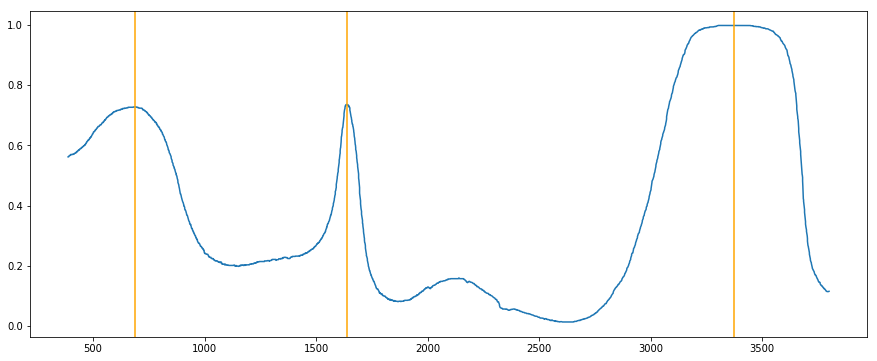

In [57]:
fig = plt.figure(figsize=(15,6))
plt.plot(x_data, y_data)
for i in range(len(peaks)):
    plt.axvline(x=peaks[i][0], color='orange')

In [58]:
# assign parameters for least squares fit
mod, pars = spectrafit.lorentz_params(peaks)

In [59]:
# fit the model to the data
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    ((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1665
    # data points      = 3917
    # variables        = 12
    chi-square         = 41.3955454
    reduced chi-square = 0.01060065
    Akaike info crit   = -17797.9899
    Bayesian info crit = -17722.7129
[[Variables]]
    p1_sigma:      284.623913 (init = 1)
    p1_center:     678.078233 (init = 688.0782)
    p1_amplitude:  669.776995 (init = 1)
    p1_fwhm:       569.247826 == '2.0000000*p1_sigma'
    p1_height:     0.72800000 (init = 0.728)
    p2_sigma:      60.3296648 (init = 1)
    p2_center:     1637.55435 (init = 1638.541)
    p2_amplitude:  123.302110 (init = 1)
    p2_fwhm:       120.659330 == '2.0000000*p2_sigma'
    p2_height:     0.73600000 (init = 0.736)
    p3_sigma:      278.504927 (init = 1)
    p3_center:     3368.23894 (init = 3373.979)
    p3_amplitude:  992.516164 (init

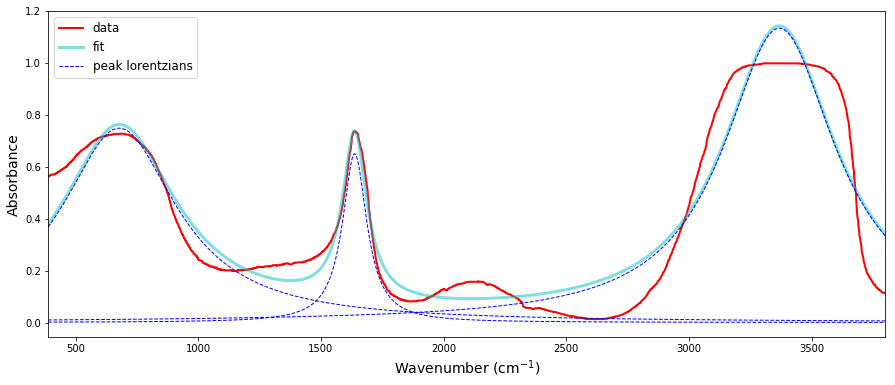

In [60]:
# plot fit results
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [61]:
# export data in logical structure (see docstring)
fit_peak_data = spectrafit.export_fit_data(out)
fit_peak_data

[array([284.62391313, 678.07823345, 669.77699528, 569.24782626,
        678.07823345]),
 array([  60.32966483, 1637.55435026,  123.30210972,  120.65932966,
        1637.55435026]),
 array([ 278.50492692, 3368.2389386 ,  992.51616391,  557.00985383,
        3368.2389386 ])]

In [62]:
# print docstring which outlines data structure
spectrafit.export_fit_data.__doc__

'\n    fit_peak_data[i][0] = p[i]_simga\n    fit_peak_data[i][1] = p[i]_center\n    fit_peak_data[i][2] = p[i]_amplitude\n    fit_peak_data[i][3] = p[i]_fwhm\n    fit_peak_data[i][4] = p[i]_center\n    '

In [66]:
peak_loc = []
peak_sigma = []
for i in range(len(fit_peak_data)):
    loc = fit_peak_data[i][1]
    sigma = fit_peak_data[i][0]
    peak_loc.append(loc)
    peak_sigma.append(sigma)


[284.6239131319124, 60.32966482798571, 278.50492691505036]